## Explore Ameriflux site data for validation with MiCASA

### Superseded to micasa-visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import glob
import datetime

In [2]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [3]:
ameriflux_ds = pd.read_csv('AmeriFlux-site-search-results-202410071335.tsv', sep='\t')

In [4]:
fluxnet = ameriflux_ds.loc[ameriflux_ds['AmeriFlux FLUXNET Data'] == 'Yes']
# fluxnet.head()

In [5]:
fluxnet_sub = fluxnet[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']]
fluxnet_sub.head()

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
5,AR-TF1,-66.7335,-54.9733,"2016, 2017, 2018"
9,BR-CST,-38.3842,-7.9682,"2014, 2015"
18,BR-Npw,-56.4120,-16.4980,"2013, 2014, 2015, 2016, 2017"
25,CA-ARB,-83.9452,52.6950,"2011, 2012, 2013, 2014, 2015"
26,CA-ARF,-83.9550,52.7008,"2011, 2012, 2013, 2014, 2015"


In [6]:
# Select a random station to start
site_ID =  'US-A32'
site_sel = fluxnet_sub.loc[fluxnet['Site ID'] == site_ID]
site_sel

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
133,US-A32,-97.8198,36.8193,"2015, 2016, 2017"


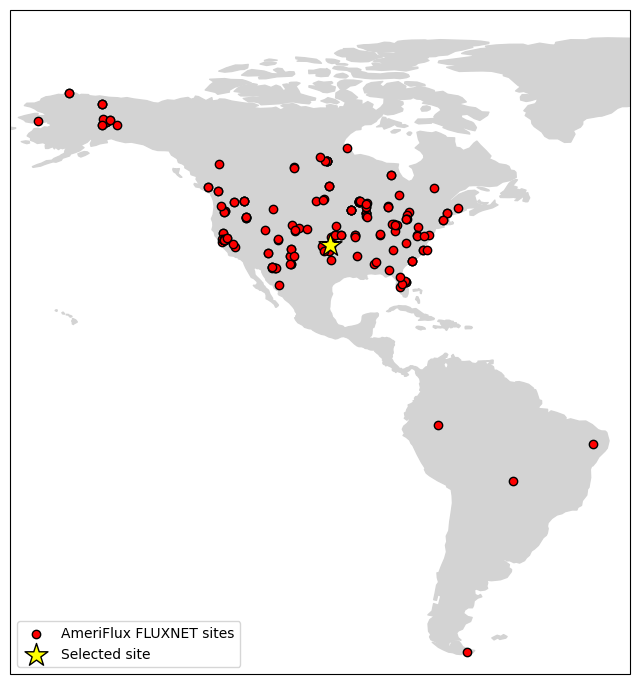

In [7]:
fig, ax = plt.subplots(figsize=(8,10),subplot_kw= {'projection': ccrs.PlateCarree()})
ax.set_extent([-170,-30,-60,90], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,color='lightgrey')


# Plot Flux sites based on lat/lon
geometry = [Point(xy) for xy in zip(fluxnet_sub['Longitude (degrees)'], fluxnet_sub['Latitude (degrees)'])]
gdf = GeoDataFrame(fluxnet, geometry=geometry)
gdf.plot(ax=ax, marker='o', color='r',  edgecolor='k',label='AmeriFlux FLUXNET sites',zorder=1);

# Plot selected
ax.scatter(site_sel['Longitude (degrees)'],site_sel['Latitude (degrees)'],marker='*', s=300, color='yellow', 
           edgecolor='black', zorder=3, label='Selected site')

ax.legend(loc='lower left')

In [14]:
# Import selected site half-hourly data (HH)
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
sel_ds = pd.read_csv(sel_file)
sel_ds.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F,SW_IN_F_QC,LW_IN_F,LW_IN_F_QC,VPD_F,...,RECO_DT_VUT_REF,RECO_DT_VUT_25,RECO_DT_VUT_50,RECO_DT_VUT_75,GPP_DT_VUT_REF,GPP_DT_VUT_25,GPP_DT_VUT_50,GPP_DT_VUT_75,RECO_SR,RECO_SR_N
0,201501010000,201501010030,-7.999,2,0.0,0.0,2,248.110,2,0.158,...,2.90789,2.90789,2.95940,3.44903,0.0,0.0,0.0,0.0,-9999,-9999
1,201501010030,201501010100,-7.934,2,0.0,0.0,2,248.110,2,0.162,...,2.91442,2.91442,2.96605,3.45678,0.0,0.0,0.0,0.0,-9999,-9999
2,201501010100,201501010130,-7.869,2,0.0,0.0,2,255.560,2,0.165,...,2.92095,2.92095,2.97270,3.46452,0.0,0.0,0.0,0.0,-9999,-9999
3,201501010130,201501010200,-7.745,2,0.0,0.0,2,255.560,2,0.166,...,2.93338,2.93338,2.98534,3.47926,0.0,0.0,0.0,0.0,-9999,-9999
4,201501010200,201501010230,-7.620,2,0.0,0.0,2,269.092,2,0.167,...,2.94588,2.94588,2.99807,3.49409,0.0,0.0,0.0,0.0,-9999,-9999


In [9]:
sel_sub = sel_ds[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF','NEE_VUT_REF_QC']]
sel_sub.head()
# units of NEE_VUT_REF: umolCO2 m-2 s-1

,TIMESTAMP_START,TIMESTAMP_END,NEE_VUT_REF,NEE_VUT_REF_QC
0,201501010000,201501010030,7.92735,3
1,201501010030,201501010100,7.71382,3
2,201501010100,201501010130,7.47549,3
3,201501010130,201501010200,7.42830,3
4,201501010200,201501010230,7.75467,3


In [10]:
sel_sub.index = pd.to_datetime(sel_sub['TIMESTAMP_START'],format='%Y%m%d%H%M')
sel_sub.index.names = ['time']
sel_sub.head()

,TIMESTAMP_START,TIMESTAMP_END,NEE_VUT_REF,NEE_VUT_REF_QC
time,,,,
2015-01-01 00:00:00,201501010000,201501010030,7.92735,3
2015-01-01 00:30:00,201501010030,201501010100,7.71382,3
2015-01-01 01:00:00,201501010100,201501010130,7.47549,3
2015-01-01 01:30:00,201501010130,201501010200,7.42830,3
2015-01-01 02:00:00,201501010200,201501010230,7.75467,3


In [11]:
# regrid to 3-hourly as in MiCASA
sel_resample = sel_sub[['NEE_VUT_REF']].resample('3h').mean()
sel_resample

,NEE_VUT_REF
time,
2015-01-01 00:00:00,7.712932
2015-01-01 03:00:00,7.443640
2015-01-01 06:00:00,-4.679067
2015-01-01 09:00:00,-23.557717
2015-01-01 12:00:00,-22.284517
...,...
2017-12-31 09:00:00,-6.382185
2017-12-31 12:00:00,-11.408590
2017-12-31 15:00:00,-6.200275


In [12]:
fluxdata_xr = sel_resample.to_xarray()

# Add lat/lon from above
fluxdata_xr['lat'] = ('index', site_sel['Latitude (degrees)'])
fluxdata_xr['lon'] = ('index', site_sel['Longitude (degrees)'])

fluxdata_xr

<xarray.Dataset> Size: 140kB
Dimensions:      (time: 8768, index: 1)
Coordinates:
  * time         (time) datetime64[ns] 70kB 2015-01-01 ... 2017-12-31T21:00:00
Dimensions without coordinates: index
Data variables:
    NEE_VUT_REF  (time) float64 70kB 7.713 7.444 -4.679 ... -6.2 8.733 8.261
    lat          (index) float64 8B 36.82
    lon          (index) float64 8B -97.82